# Venmo Customer Churn



### Setting up the Spark and Loading the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Run below commands
!echo "setup Colab for PySpark $PYSPARK and Spark NLP $SPARKNLP"
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install spark-nlp==4.4.0

setup Colab for PySpark  and Spark NLP 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.4/486.4 kB 6.6 MB/s eta 0:00:00


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [4]:

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col,datediff,when, lit,
                                   regexp_replace,max,min, year,concat,month,lag,
                                   coalesce,array_contains,length,udf,size,split,
                                   explode, arrays_zip, mean, collect_list,concat_ws,avg)


import random
import pandas as pd
#Spark ML and SQL
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from pyspark.sql.functions import col
#Spark NLP
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import DocumentAssembler, Finisher
from pyspark.sql.types import StringType
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, IntegerType

In [5]:
spark = sparknlp.start()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
# spark.conf.set()


In [6]:
spark

In [7]:
venmo = spark.read.parquet("drive/Shareddrives/Venmo_Project/VenmoSample.snappy.parquet")

### Creation of Churn Columns

In [8]:
venmo = venmo.withColumn("year_month", concat(year(col("datetime")).cast(StringType() ), lit("-"),
                                              when(month(col("datetime")) <10,
                                                   concat(lit("0"), month(col("datetime")).cast(StringType()))).otherwise(month(col("datetime")).cast(StringType())) ))

window_y_var = Window.partitionBy("user1")

venmo = venmo.withColumn("max_year_month", max(col("year_month")).over(window_y_var)).withColumn("min_year_month", min(col("year_month")).over(window_y_var))

venmo = venmo.filter(col("min_year_month") < "2014-06")


In [9]:
venmo = venmo.withColumn("churn", when(col("max_year_month") < "2014-06", 1).otherwise(0))

In [10]:
venmo = venmo.cache()

### Text Data Preparation



In [11]:
emoji_pattern = u'[^\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]'
venmo = venmo.withColumn("emoji_only",regexp_replace(col('description'), emoji_pattern, ''))
punc_pattern = r'[^,|\.|&|\\|\||-|_|!]'
venmo = venmo.withColumn("punctuations", regexp_replace("description", punc_pattern, ""))
textonly_pattern = r'[^\w\s]|_'
venmo = venmo.withColumn("text_only",regexp_replace(col('description'), textonly_pattern, ''))

In [12]:
venmo = venmo.withColumn("text_only", when(col("text_only") == " ", None).otherwise(col("text_only")))
venmo = venmo.withColumn("punctuations", when(col("punctuations") == "", None).otherwise(col("punctuations")))
venmo = venmo.withColumn("emoji_only", when(col("emoji_only") == "", None).otherwise(col("emoji_only")))

In [13]:
venmo = venmo.withColumn("characteronly_length", length("text_only"))
venmo = venmo.withColumn("punctuations_length", length("punctuations"))
venmo = venmo.withColumn("emoji_length", length("emoji_only"))

In [14]:
### User Level Aggregation
venmo_user = venmo.groupBy("user1") \
              .agg(avg("churn").alias("churn"), \
                   concat_ws(" ",collect_list("text_only")).alias("text_only"))
venmo_user = venmo_user.filter(col('text_only').isNotNull() | (col('text_only') != ''))

In [15]:
### User Level Aggregation
venmo_user = venmo.groupBy("user1") \
              .agg(avg("churn").alias("churn"), \
                   min("datetime").alias("customer_join_Date"),\
                   avg("characteronly_length").alias("avg_characteronly_length"), \
                   avg("punctuations_length").alias("avg_punctuations_length"), \
                   avg("emoji_length").alias("avg_emoji_length"), \
                   concat_ws(" ",collect_list("punctuations")).alias("punctuations"),\
                   concat_ws(" ",collect_list("emoji_only")).alias("emoji_only"),\
                   concat_ws(" ", collect_list("text_only")).alias("text_only"))

### Descriptive Statistics

In [16]:
venmo_user.groupBy('churn').count()

churn,count
0.0,105647
1.0,27556


In [17]:
venmo_user.withColumn('join_year', year('customer_join_Date')) \
               .groupBy('join_year', 'churn') \
               .count()

join_year,churn,count
2012,1.0,1699
2011,0.0,2
2011,1.0,2
2013,0.0,36387
2012,0.0,2144
2014,1.0,14852
2013,1.0,11003
2014,0.0,67114


In [18]:
venmo_user.groupBy('churn').agg(avg('avg_characteronly_length').alias('character_length'),\
                                avg('avg_punctuations_length').alias('punctuation_length'),\
                                avg('avg_emoji_length').alias('emoji_length'))

churn,character_length,punctuation_length,emoji_length
0.0,11.353546826258645,1.7344078299168657,2.267132210338817
1.0,14.791064078390034,1.69310174919931,2.2638108189785426


## Model Development

In [19]:
# Perform stratified sampling
venmo_user =  venmo_user.fillna(0)
venmo_train = venmo_user.sampleBy('churn', fractions={0: 0.7, 1: 0.7}, seed=10)
venmo_test = venmo_user.subtract(venmo_train)

In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(inputCols=["avg_characteronly_length","avg_punctuations_length","avg_emoji_length"], outputCol="features")
training_data = assembler.transform(venmo_train)
testing_data = assembler.transform(venmo_test)

In [21]:
training_data.groupBy('churn').count()

churn,count
0.0,73876
1.0,19276


In [22]:
testing_data.groupBy('churn').count()

churn,count
0.0,31765
1.0,8286


### Logistic Regression with Count Variables

In [23]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(family="binomial", maxIter=100, featuresCol='features',labelCol='churn')

# Fit the model
model = glr.fit(training_data)

# Summarize the model over the training set and print out some metrics
summary = model.summary
print(summary)

Coefficients:
             Feature Estimate Std Error  T Value P Value
         (Intercept)  -0.5386    0.0160 -33.7362  0.0000
avg_characteronly...   0.0262    0.0009  27.8479  0.0000
avg_punctuations_...  -0.5342    0.0133 -40.1019  0.0000
    avg_emoji_length  -1.5221    0.0170 -89.6653  0.0000

(Dispersion parameter for binomial family taken to be 1.0000)
    Null deviance: 94989.2292 on 93148 degrees of freedom
Residual deviance: 72320.4353 on 93148 degrees of freedom
AIC: 72328.4353


In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction_label", labelCol="churn")
predictions = model.transform(training_data)
threshold = 0.5
predictions = predictions.withColumn('prediction_label', when(predictions['prediction'] >= threshold, 1).otherwise(0))
predictions = predictions.withColumn('prediction_label', col('prediction_label').cast('double'))
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Train AUC: {:.4f}".format(auc))

Train AUC: 0.5563


In [25]:
predictions = model.transform(testing_data)
threshold = 0.5
predictions = predictions.withColumn('prediction_label', when(predictions['prediction'] >= threshold, 1).otherwise(0))
predictions = predictions.withColumn('prediction_label', col('prediction_label').cast('double'))
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Test AUC: {:.4f}".format(auc))

Test AUC: 0.5516


In [26]:
predictions.crosstab('churn', 'prediction_label').show()

+----------------------+-----+---+
|churn_prediction_label|  0.0|1.0|
+----------------------+-----+---+
|                   1.0| 7298|988|
|                   0.0|31253|512|
+----------------------+-----+---+



In [27]:
print("Precision: ",(988/(988+512)))
print("Recall: ",(988/(988+7298)))

Precision:  0.6586666666666666
Recall:  0.11923726768042481


### LIWC Variables Inclusion

In [28]:
venmo_liwc = spark.read.csv("drive/Shareddrives/Venmo_Project/data/liwc_results.csv", header=True, inferSchema=True)
venmo_train = venmo_train.join(venmo_liwc, venmo_train.user1 == venmo_liwc.user1, "left")
venmo_train = venmo_train.fillna(0)
venmo_test = venmo_test.join(venmo_liwc, venmo_test.user1 == venmo_liwc.user1, "left")
venmo_test = venmo_test.fillna(0)

In [29]:
features_list = ['Dic','avg_characteronly_length','avg_punctuations_length','avg_emoji_length','WC','BigWords'
 ,'pronoun','ppron','i','we','you','shehe','they','ipron','det','article','number','prep','auxverb','adverb','conj','negate', 'verb', 'adj', 'quantity', 'Drives',
 'affiliation','achieve','power','Cognition','allnone','cogproc','insight','cause','discrep','tentat','certitude','differ','memory','Affect',
 'tone_pos','tone_neg','emotion','emo_pos','emo_neg','emo_anx','emo_anger','emo_sad','swear','Social','socbehav','prosocial','polite','conflict','moral',
 'comm','socrefs','family','friend','Culture','politic','ethnicity','tech','Lifestyle','leisure','home','work','money','relig','Physical','health','illness',
 'wellness','mental','substances','sexual','food','death','need','want','acquire','lack','fulfill','fatigue','reward','risk','curiosity','allure',
 'Perception', 'attention','motion', 'space', 'visual', 'auditory', 'feeling', 'time', 'focuspast', 'focuspresent', 'focusfuture', 'Conversation', 'netspeak', 'assent', 'nonflu', 'filler']

In [30]:
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
training_data = assembler.transform(venmo_train)
testing_data = assembler.transform(venmo_test)

In [31]:
# IMPORT
import numpy as np
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier


# BUILD THE MODEL
rf = RandomForestClassifier(numTrees=1000, maxDepth=5, labelCol="churn", seed=42,subsamplingRate=0.4)
model = rf.fit(training_data)

# FEATURE IMPORTANCES

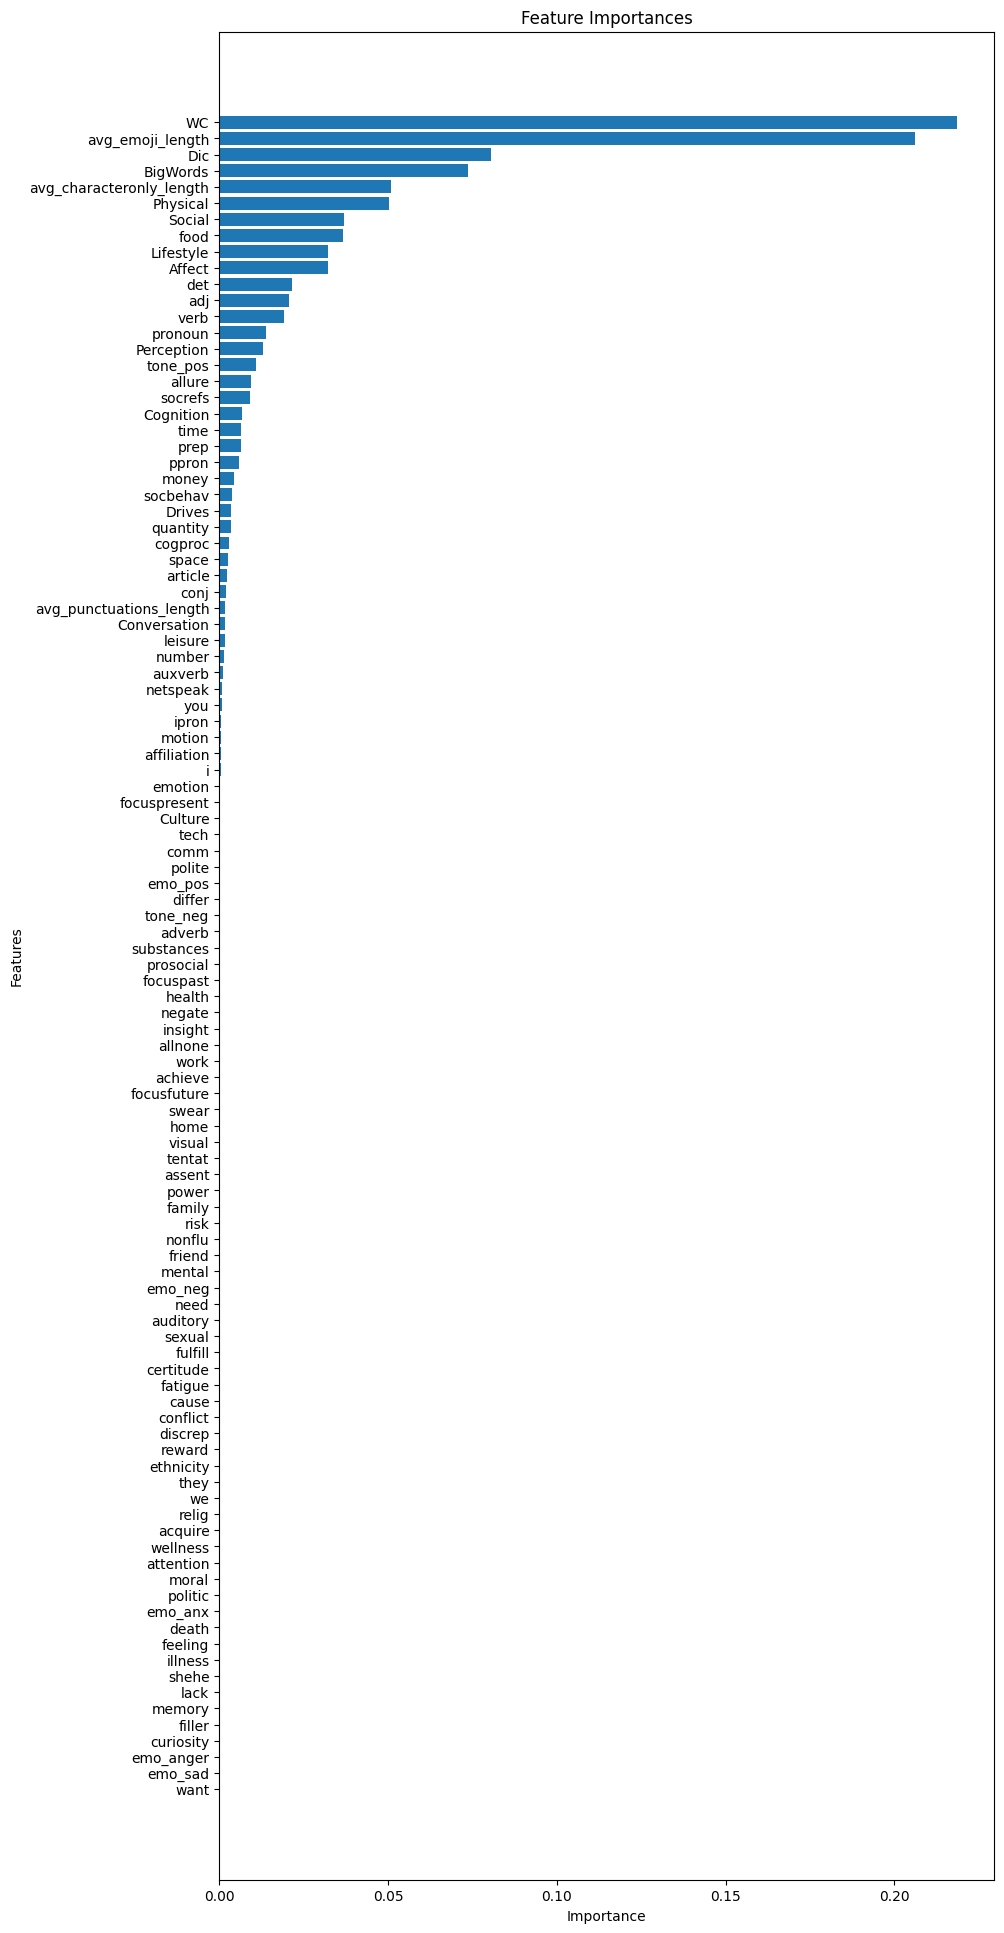

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out zero importance features
non_zero_indices = list(model.featureImportances.indices)
non_zero_importances = list(model.featureImportances.values)
non_zero_features = [features_list[index] for index in non_zero_indices]

# Sort the features by importance in decreasing order
sorted_indices = np.argsort(non_zero_importances)
non_zero_indices = [non_zero_indices[i] for i in sorted_indices]
non_zero_importances = [non_zero_importances[i] for i in sorted_indices]
non_zero_features = [non_zero_features[i] for i in sorted_indices]

# Increase the size of the plot
plt.figure(figsize=(10, 24))

# Creating the bar chart
plt.barh(np.arange(len(non_zero_features)), non_zero_importances, align='center')
plt.yticks(np.arange(len(non_zero_features)), non_zero_features)

# Adding labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

# Displaying the chart
plt.show()

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction_label", labelCol="churn")
predictions = model.transform(training_data)
threshold = 0.5
predictions = predictions.withColumn('prediction_label', when(predictions['prediction'] >= threshold, 1).otherwise(0))
predictions = predictions.withColumn('prediction_label', col('prediction_label').cast('double'))
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Train AUC: {:.4f}".format(auc))

Train AUC: 0.7890


In [34]:
predictions = model.transform(testing_data)
threshold = 0.5
predictions = predictions.withColumn('prediction_label', when(predictions['prediction'] >= threshold, 1).otherwise(0))
predictions = predictions.withColumn('prediction_label', col('prediction_label').cast('double'))
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Test AUC: {:.4f}".format(auc))

Test AUC: 0.7912


In [35]:
predictions.crosstab('churn', 'prediction_label').show()

+----------------------+-----+----+
|churn_prediction_label|  0.0| 1.0|
+----------------------+-----+----+
|                   1.0| 3305|4981|
|                   0.0|31173| 592|
+----------------------+-----+----+



In [36]:
print("Precision: ",(4981/(4981+592)))
print("Recall: ",(4981/(4981+3305)))

Precision:  0.8937735510497039
Recall:  0.6011344436398744


### Model Development in Pandas, as sample being smaller size

In [37]:
!pip install shap
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.0 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [38]:
df_train = venmo_train.toPandas()
df_test = venmo_test.toPandas()

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

In [39]:
rf = RandomForestClassifier(n_estimators=1000, criterion='log_loss', max_depth=10, min_samples_split=50, min_samples_leaf=25,
                            max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=True, n_jobs=-1, random_state=1000,
                            verbose=3, warm_start=False)
rf.fit(df_train[features_list], df_train['churn'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.3s


building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000building tree 46 of 1000

building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   33.5s


building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000
building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   59.1s


building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000
building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  1.5min


building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000
building tree 533 of 1000
building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tree 546 of 1000
building tree 547 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.2min


building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 820 of 1000
building tree 821 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tree 826 of 1000
building tree 827 of 1000
building tree 828 of 1000
building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.7min finished


RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=25,
                       min_samples_split=50, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=1000, verbose=3)

In [40]:
rf.oob_score_

0.9298243730676743

In [41]:
y_pred = rf.predict(df_test[features_list])
precision = precision_score(df_test['churn'], y_pred)
recall = recall_score(df_test['churn'], y_pred)
print(precision)
print(recall)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    7.4s


0.8960982658959538
0.7483707458363504


[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    9.3s finished


In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test['churn'], y_pred)

0.9299892636887968

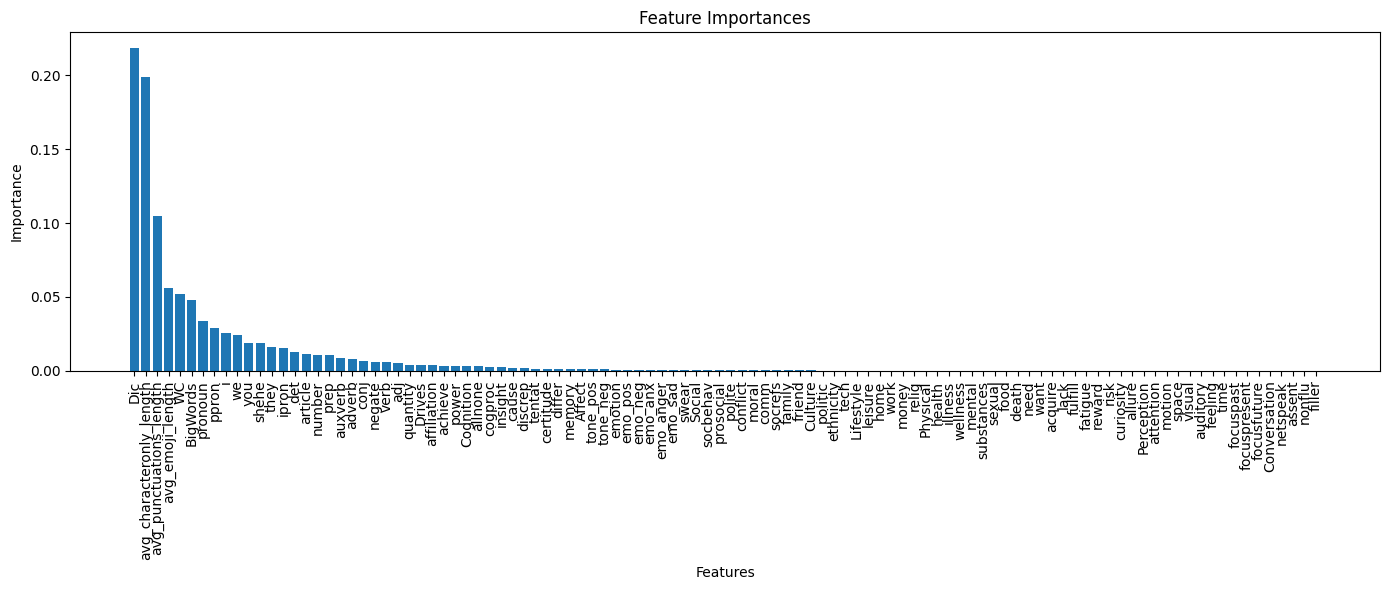

In [43]:
import matplotlib.pyplot as plt
feature_importance = rf.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_features = features_list

plt.figure(figsize=(14, 6))
plt.bar(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [44]:
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(df_test[features_list])

In [45]:
# shap.summary_plot(shap_values, df_test[features_list])

In [46]:
# shap.summary_plot(shap_values[1], df_test[features_list])

In [47]:
# shap.summary_plot(shap_values[0], df_test[features_list])

### Word Embdeddings and Model Development

In [48]:
# Spark NLP Pipeline
### Text Tokens
document_assembler = DocumentAssembler() \
    .setInputCol("text_only")

documentNormalizer = DocumentNormalizer() \
    .setInputCols("document") \
    .setOutputCol("normalizedDocument") \
    .setLowercase(True)

sentence_detector = SentenceDetector() \
    .setInputCols(["normalizedDocument"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["token"]) \
    .setOutputCol("token_lemma")

finisher = Finisher() \
    .setInputCols(["token_lemma"]) \
    .setOutputCols(["text_tokens"]) \
    .setIncludeMetadata(False) \
    .setOutputAsArray(True)

nlpPipeline = Pipeline(stages=[
    document_assembler,
    documentNormalizer,
    sentence_detector,
    tokenizer,
    lemmatizer,
    finisher
])

### Emoji Tokens
document_assembler_emoji = DocumentAssembler() \
    .setInputCol("emoji_only")

sentence_detector_emoji = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer_emoji = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

finisher_emoji = Finisher() \
    .setInputCols(["token"]) \
    .setOutputCols(["emoji_tokens"]) \
    .setIncludeMetadata(False) \
    .setOutputAsArray(True)

nlpPipeline_emoji = Pipeline(stages=[
    document_assembler_emoji,
    sentence_detector_emoji,
    tokenizer_emoji,
    finisher_emoji
])

### punctuations
document_assembler_punc = DocumentAssembler() \
    .setInputCol("punctuations")

sentence_detector_punc = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer_punc= Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

finisher_punc = Finisher() \
    .setInputCols(["token"]) \
    .setOutputCols(["punctuation_tokens"]) \
    .setIncludeMetadata(False) \
    .setOutputAsArray(True)

nlpPipeline_punc = Pipeline(stages=[
    document_assembler_punc,
    sentence_detector_punc,
    tokenizer_punc,
    finisher_punc
])



lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [49]:
venmo_user = nlpPipeline.fit(venmo_user).transform(venmo_user)
venmo_user = nlpPipeline_emoji.fit(venmo_user).transform(venmo_user)
venmo_user = nlpPipeline_punc.fit(venmo_user).transform(venmo_user)

In [50]:
# Perform stratified sampling
venmo_user =  venmo_user.fillna(0)
venmo_train = venmo_user.sampleBy('churn', fractions={0: 0.7, 1: 0.7}, seed=10)
venmo_test = venmo_user.subtract(venmo_train)

In [51]:
from pyspark.ml.feature import HashingTF, IDF

In [52]:
hashingTF = HashingTF(inputCol="text_tokens", outputCol="countfeatures")

idf = IDF(inputCol="countfeatures", outputCol="tf_idf_features", minDocFreq=5) #minDocFreq: remove sparse terms

nlp_pipeline_tf = Pipeline(
    stages=[
            hashingTF,
            idf
            ])

nlp_model_tf = nlp_pipeline_tf.fit(venmo_train)

In [53]:
venmo_train = nlp_model_tf.transform(venmo_train)
venmo_test = nlp_model_tf.transform(venmo_test)

### Count Features and Modelling

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator


assembler = VectorAssembler(inputCols=["countfeatures"], outputCol="features")
training_data = assembler.transform(venmo_train)

# rf = RandomForestClassifier(numTrees=100, maxDepth=5, labelCol="churn", seed=42,subsamplingRate=0.4)
# model = rf.fit(training_data)

lr = LogisticRegression(featuresCol="features", labelCol="churn")
model = lr.fit(training_data)

# make predictions on the testing data
predictions = model.transform(training_data)
predictions.show(1,0)


evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="churn")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Train AUC: {:.4f}".format(auc))

# create a feature vector from the "name" column in the testing data
testing_data = assembler.transform(venmo_test)

# make predictions on the testing data
predictions = model.transform(testing_data)
predictions.show(1,0)


evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="churn")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Test AUC: {:.4f}".format(auc))

### TF-IDF Features and Model Development

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(inputCols=["tf_idf_features"], outputCol="features")
training_data = assembler.transform(venmo_train)


lr = LogisticRegression(featuresCol="features", labelCol="churn")
model = lr.fit(training_data)

In [ ]:
# make predictions on the testing data
predictions = model.transform(training_data)
predictions.show(1,0)


evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="churn")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Train AUC: {:.4f}".format(auc))

# create a feature vector from the "name" column in the testing data
testing_data = assembler.transform(venmo_test)

# make predictions on the testing data
predictions = model.transform(testing_data)
predictions.show(1,0)


evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="churn")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Test AUC: {:.4f}".format(auc))

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="churn")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("AUC: {:.4f}".format(auc))

In [ ]:
from pyspark.ml.feature import CountVectorizer, IDF

# Define the input data
data = [("example",),
        ("yet",),
        ("example another yet example",)]

df = spark.createDataFrame(data, ["text_only"])
from pyspark.sql.functions import split

df = nlpPipeline.fit(df).transform(df)

df = nlp_pipeline_tf.fit(df).transform(df)
df.show(3,0)